In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit
from algo.utils import process_hamiltonian_Zs

from qiskit_algorithms import NumPyMinimumEigensolver
from algo.oicd import oicd
from algo.utils import (
    expectation_loss_grad,
    interp_matrix,
    optimal_interp_points,
    mse
)

array([[ 1.00000000e+00, -1.82313678e-17,  2.33742365e-16],
       [-4.21546981e-17,  1.00000000e+00,  1.76271580e-16],
       [ 1.62206525e-16,  2.47807420e-16,  1.00000000e+00]])

In [ ]:
import matplotlib

# Update matplotlib settings with specified fonts and sizes
fontsize = 20
# 全局设置 dpi 和 bbox_inches
matplotlib.rcParams.update({
    'savefig.dpi': 300,  # 设置保存图像时的 DPI
    'savefig.bbox': 'tight',  # 设置保存时去除空白区域
    'font.family': 'serif',
    'axes.labelsize': fontsize,
    'font.size': fontsize,
    'legend.fontsize': 12,
    'axes.titlesize': 20,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'lines.linewidth': 3,
    # 'text.usetex': True,
    'figure.figsize': (6, 5), ###
})
# Define custom color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [3]:
ham_str = '0.5 - 3 * z0  + 0.5 * z1 * z0 + 0.5 * z2 * z0 + 0.5 * z2 * z1 + 0.5 * z3 * z0 + 0.5 * z3 * z2'

# global
num_q = 4  # Number of qubits
layer = 5
num_p = layer * num_q

In [4]:
max_stars = 2  # Maximum number of stars to categorize terms (e.g., 0-star, 1-star, 2-star, 3-star)
# Call the function to process the Hamiltonian string
all_lists, all_coeffs = process_hamiltonian_Zs(ham_str, num_q, max_stars)

# Output the results for each star category
for i, (term_positions, term_coeffs) in enumerate(zip(all_lists, all_coeffs)):
    print(f"Terms with {i} star(s):")
    print("Coefficients:", term_coeffs)
    print("Positions:", term_positions)

print('')

List_0, List_1, List_2 = all_lists
List = List_0 + List_1 + List_2

coeff_0, coeff_1, coeff_2 = all_coeffs
coeff = coeff_0 + coeff_1 + coeff_2

H = SparsePauliOp(List, coeff)
print(H)

Terms with 0 star(s):
Coefficients: [0.5]
Positions: ['IIII']
Terms with 1 star(s):
Coefficients: [-3.0]
Positions: ['ZIII']
Terms with 2 star(s):
Coefficients: [0.5, 0.5, 0.5, 0.5, 0.5]
Positions: ['ZZII', 'ZIZI', 'IZZI', 'ZIIZ', 'IIZZ']

SparsePauliOp(['IIII', 'ZIII', 'ZZII', 'ZIZI', 'IZZI', 'ZIIZ', 'IIZZ'],
              coeffs=[ 0.5+0.j, -3. +0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j])


In [5]:
H_matrix = H.to_matrix()
H_matrix_squared = H_matrix @ H_matrix
H_squared = SparsePauliOp.from_operator(H_matrix_squared)

In [6]:
H_squared

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'ZIII', 'ZIIZ', 'ZIZI', 'ZIZZ', 'ZZII', 'ZZZI', 'ZZZZ'],
              coeffs=[10.5+0.j, -3. +0.j, -3. +0.j,  1. +0.j, -3. +0.j,  1. +0.j,  1. +0.j,
 -3. +0.j,  1. +0.j,  1.5+0.j, -3. +0.j,  1. +0.j, -3. +0.j,  1. +0.j])

In [7]:
# Directly use NumPyMinimumEigensolver
eigensolver = NumPyMinimumEigensolver()
result = eigensolver.compute_minimum_eigenvalue(operator=H)

# Extract the ground state energy and ground state vector
ground_energy = result.eigenvalue.real
# ground_state = result.eigenstate  # This is a statevector

print(f"Ground state energy = {ground_energy}")
# print(f"Ground state vector = {ground_state}")


Ground state energy = -3.9999999999999964


In [8]:
def circuit_HEA(num_q: int, layer: int):

    num_p = num_q * layer
    theta = ParameterVector("θ", num_p)
    
    circ = QuantumCircuit(num_q)
    
    for i in range(layer):  # Iterate over each layer
        for j in range(num_q): 
            circ.ry(theta[num_q*i+j], j)  # Apply RY gate to each qubit, the angle is given by elements in the weights array
        for j in range(num_q-1):  
            circ.cz(j, j+1) # Apply CZ gate to each pair of adjacent qubits
    
    return circ, theta

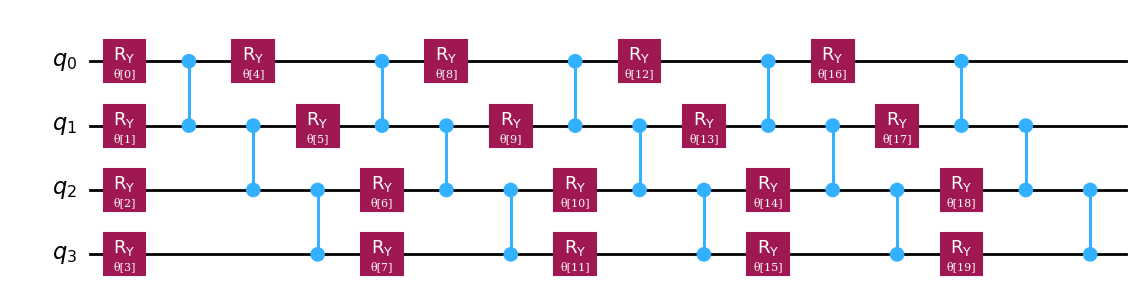

In [9]:
qc, _ = circuit_HEA(num_q, layer)
# print(qc)
qc.draw("mpl")

In [10]:

def expectation_loss(weights):
    return expectation_loss_grad(num_q,
                                 layer,
                                 weights,
                                 circuit=circuit_HEA,
                                 obs=H,
                                 )


def estimate_loss(weights, shots):
    return expectation_loss_grad(num_q,
                                 layer,
                                 weights,
                                 circuit=circuit_HEA,
                                 obs=H,
                                 shots=shots)

# ture variance
def variance(weights):
    result = expectation_loss_grad(num_q,
                            layer,
                            weights,
                            circuit=circuit_HEA,
                            obs=H_squared,
                            ) \
    - expectation_loss(weights)**2
    return result

In [11]:
tol=1e-2
plot_flag=True
initial_weights = np.random.uniform(0, 2*np.pi, size=num_p)
print(f"Ground state energy: {ground_energy}")

Ground state energy: -3.9999999999999964


In [12]:
variance(initial_weights)

6.330783164996056

# minimize nonconstant variance

In [13]:
n_shot = 1024
num_iter = 250  # Number of iterations for optimization


In [14]:
omegas = [1]

weights_dict = {}
all_metrics = []

for i in range(num_p):
    weights_dict[f'weights_{i}'] = {
        'omegas': omegas,
        'scale_factor': 1.0,
        # 'interp_nodes': interp_nodes,
        # 'inverse_interp_matrix': inverse_interp_matrix,
    }

In [15]:
from algo.oicd_var import oicd_var

mses_const, _, _, best_expected_record_value_oicd, func_oicd, _, metric_oicd = oicd_var(
    estimate_loss,
    expectation_loss,
    variance,
    ground_energy,
    n_shot, weights_dict, initial_weights, num_iter,
    cyclic_mode=True, # !!!!!!!!!!!
    use_pratical_interp_flag=False, # !!!!!!!!!!!
    use_local_solvers_flag=False,
    use_global_solvers_flag = False,
    use_eigen_method_flag = True,
    use_exact_update_frequencey_1_flag = False,
    exact_mode=False,  # !!!!!!!!!!!
    plot_flag=False,
    plot_argmin_flag=False,
    tol = tol,
    refresh_print_bar=True,
    mse='constant'
)
all_metrics.append(metric_oicd)

----------------------------------------------------------------------------------------------------


Bar desc:   0%|          | 0/250 [00:00<?, ?it/s]

[OICD-var] Iter: 0, 0(20), Metric: 2.4907, Elapsed: 53.77s:   0%|          | 1/250 [00:53<3:43:09, 53.77s/it]

iteration 0
opt_mse_var 18.15941703085852
opt_mse_const 1.9999986666689586
mse_const for optimal nodes of mse_var 2.0824805036098932
mse_var for optimal nodes of mse_const 18.78191943437895



[OICD-var] Iter: 1, 1(20), Metric: 2.4816, Elapsed: 39.61s:   1%|          | 2/250 [01:33<3:07:50, 45.44s/it]

iteration 1
opt_mse_var 11.029716222673512
opt_mse_const 1.999998666667812
mse_const for optimal nodes of mse_var 2.072467789726787
mse_var for optimal nodes of mse_const 11.3928624717886



[OICD-var] Iter: 2, 2(20), Metric: 1.7190, Elapsed: 48.37s:   1%|          | 3/250 [02:21<3:12:35, 46.78s/it]

iteration 2
opt_mse_var 11.769169426646645
opt_mse_const 1.9999986666675569
mse_const for optimal nodes of mse_var 2.12396896589195
mse_var for optimal nodes of mse_const 12.323387999771453



[OICD-var] Iter: 3, 3(20), Metric: 1.5135, Elapsed: 27.70s:   2%|▏         | 4/250 [02:49<2:40:54, 39.25s/it]

iteration 3
opt_mse_var 8.409797017164745
opt_mse_const 1.9999986666675575
mse_const for optimal nodes of mse_var 2.1111726020936823
mse_var for optimal nodes of mse_const 8.751216829689108



[OICD-var] Iter: 4, 4(20), Metric: 1.4990, Elapsed: 41.96s:   2%|▏         | 5/250 [03:31<2:44:15, 40.23s/it]

iteration 4
opt_mse_var 12.226905055908013
opt_mse_const 1.9999986666675569
mse_const for optimal nodes of mse_var 2.3346078859757653
mse_var for optimal nodes of mse_const 13.525637636865456



[OICD-var] Iter: 5, 5(20), Metric: 1.4977, Elapsed: 64.65s:   2%|▏         | 6/250 [04:36<3:17:21, 48.53s/it]

iteration 5
opt_mse_var 9.016960140792987
opt_mse_const 1.9999986666675569
mse_const for optimal nodes of mse_var 2.406804060117864
mse_var for optimal nodes of mse_const 10.431385852447015



[OICD-var] Iter: 6, 6(20), Metric: 1.2163, Elapsed: 57.01s:   3%|▎         | 7/250 [05:33<3:27:46, 51.30s/it]

iteration 6
opt_mse_var 10.771931031350457
opt_mse_const 1.9999986666675555
mse_const for optimal nodes of mse_var 2.4691262460641723
mse_var for optimal nodes of mse_const 12.164014051844907



[OICD-var] Iter: 7, 7(20), Metric: 1.2038, Elapsed: 42.74s:   3%|▎         | 8/250 [06:15<3:15:55, 48.58s/it]

iteration 7
opt_mse_var 3.586970867377869
opt_mse_const 1.9999986666675582
mse_const for optimal nodes of mse_var 2.038718672207329
mse_var for optimal nodes of mse_const 3.6471808727817985



[OICD-var] Iter: 8, 8(20), Metric: 1.1245, Elapsed: 41.36s:   4%|▎         | 9/250 [06:57<3:06:03, 46.32s/it]

iteration 8
opt_mse_var 1.8315457605507217
opt_mse_const 1.9999986666675933
mse_const for optimal nodes of mse_var 2.000567047190078
mse_var for optimal nodes of mse_const 1.8320642894070707



[OICD-var] Iter: 9, 9(20), Metric: 1.1207, Elapsed: 75.42s:   4%|▍         | 10/250 [08:12<3:41:13, 55.31s/it]

iteration 9
opt_mse_var 7.375484784725366
opt_mse_const 1.9999986666676732
mse_const for optimal nodes of mse_var 3.1003871443512487
mse_var for optimal nodes of mse_const 10.138294420506668



[OICD-var] Iter: 10, 10(20), Metric: 1.0593, Elapsed: 67.94s:   4%|▍         | 11/250 [09:20<3:55:42, 59.17s/it]

iteration 10
opt_mse_var 8.030432746730098
opt_mse_const 1.9999986666677614
mse_const for optimal nodes of mse_var 4.136151083958248
mse_var for optimal nodes of mse_const 12.454653629937141



[OICD-var] Iter: 11, 11(20), Metric: 1.0185, Elapsed: 41.72s:   5%|▍         | 12/250 [10:02<3:33:39, 53.86s/it]

iteration 11
opt_mse_var 1.2507966666967774
opt_mse_const 1.999998666667557
mse_const for optimal nodes of mse_var 2.0060618011501905
mse_var for optimal nodes of mse_const 1.2544572673765575



[OICD-var] Iter: 12, 12(20), Metric: 1.0005, Elapsed: 26.64s:   5%|▌         | 13/250 [10:28<3:00:10, 45.62s/it]

iteration 12
opt_mse_var 0.9892765653072393
opt_mse_const 1.999998666667559
mse_const for optimal nodes of mse_var 2.004102239979365
mse_var for optimal nodes of mse_const 0.991277781154785



[OICD-var] Iter: 13, 13(20), Metric: 0.9549, Elapsed: 72.92s:   6%|▌         | 14/250 [11:41<3:31:51, 53.86s/it]

iteration 13
opt_mse_var 2.657263145960451
opt_mse_const 1.9999986666675755
mse_const for optimal nodes of mse_var 2.318563497021276
mse_var for optimal nodes of mse_const 2.942643545214013



[OICD-var] Iter: 14, 14(20), Metric: 0.9459, Elapsed: 52.30s:   6%|▌         | 15/250 [12:34<3:29:07, 53.39s/it]

iteration 14
opt_mse_var 9.374146708793116
opt_mse_const 1.9999986666675555
mse_const for optimal nodes of mse_var 4.3621652842802865
mse_var for optimal nodes of mse_const 14.578752459261214



[OICD-var] Iter: 15, 15(20), Metric: 0.9236, Elapsed: 54.35s:   6%|▋         | 16/250 [13:28<3:29:21, 53.68s/it]

iteration 15
opt_mse_var 6.426713328763405
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 4.622632047352506
mse_var for optimal nodes of mse_const 9.972916326901146



[OICD-var] Iter: 16, 16(20), Metric: 0.9171, Elapsed: 49.60s:   7%|▋         | 17/250 [14:18<3:23:42, 52.46s/it]

iteration 16
opt_mse_var 0.31864580591310543
opt_mse_const 1.9999986666675778
mse_const for optimal nodes of mse_var 2.003497585333321
mse_var for optimal nodes of mse_const 0.3191955973305154



[OICD-var] Iter: 17, 17(20), Metric: 0.9057, Elapsed: 52.35s:   7%|▋         | 18/250 [15:10<3:22:42, 52.43s/it]

iteration 17
opt_mse_var 2.215644968735163
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 2.7775920208427287
mse_var for optimal nodes of mse_const 2.667862113570883



[OICD-var] Iter: 18, 18(20), Metric: 0.9030, Elapsed: 44.19s:   8%|▊         | 19/250 [15:54<3:12:19, 49.95s/it]

iteration 18
opt_mse_var 0.27897910710572227
opt_mse_const 1.999998666667613
mse_const for optimal nodes of mse_var 2.0020489213142247
mse_var for optimal nodes of mse_const 0.27926096317275345



[OICD-var] Iter: 19, 19(20), Metric: 0.9031, Elapsed: 34.92s:   8%|▊         | 20/250 [16:29<2:54:11, 45.44s/it]

iteration 19
opt_mse_var 6.2619702359959035
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 4.872915945159825
mse_var for optimal nodes of mse_const 9.865419497097394



[OICD-var] Iter: 20, 0(20), Metric: 0.9030, Elapsed: 55.75s:   8%|▊         | 21/250 [17:25<3:05:14, 48.54s/it] 

iteration 20
opt_mse_var 9.757758496592414
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 4.09963321738673
mse_var for optimal nodes of mse_const 12.4889215891602



[OICD-var] Iter: 21, 1(20), Metric: 0.9029, Elapsed: 41.68s:   9%|▉         | 22/250 [18:06<2:56:37, 46.48s/it]

iteration 21
opt_mse_var 10.110795908054108
opt_mse_const 1.9999986666675569
mse_const for optimal nodes of mse_var 3.4902956375809358
mse_var for optimal nodes of mse_const 12.093311808003742



[OICD-var] Iter: 22, 2(20), Metric: 0.9033, Elapsed: 38.27s:   9%|▉         | 23/250 [18:45<2:46:31, 44.02s/it]

iteration 22
opt_mse_var 8.345725407557406
opt_mse_const 1.999998666667562
mse_const for optimal nodes of mse_var 3.4144714730542924
mse_var for optimal nodes of mse_const 9.929091849496192



[OICD-var] Iter: 23, 3(20), Metric: 0.9062, Elapsed: 37.06s:  10%|▉         | 24/250 [19:22<2:37:55, 41.93s/it]

iteration 23
opt_mse_var 4.76734075790515
opt_mse_const 1.9999986666675558
mse_const for optimal nodes of mse_var 2.6275363771090348
mse_var for optimal nodes of mse_const 5.301509593363727



[OICD-var] Iter: 24, 4(20), Metric: 0.9067, Elapsed: 52.42s:  10%|█         | 25/250 [20:14<2:49:02, 45.08s/it]

iteration 24
opt_mse_var 10.669201554642484
opt_mse_const 1.999998666667623
mse_const for optimal nodes of mse_var 3.2649112784262053
mse_var for optimal nodes of mse_const 13.147308956280046



[OICD-var] Iter: 25, 5(20), Metric: 0.9061, Elapsed: 51.14s:  10%|█         | 26/250 [21:05<2:55:04, 46.89s/it]

iteration 25
opt_mse_var 6.844584244350838
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 3.64261377023697
mse_var for optimal nodes of mse_const 9.898227313721796



[OICD-var] Iter: 26, 6(20), Metric: 0.8258, Elapsed: 29.65s:  11%|█         | 27/250 [21:35<2:35:04, 41.72s/it]

iteration 26
opt_mse_var 9.190709280101528
opt_mse_const 1.9999986666676457
mse_const for optimal nodes of mse_var 2.5493278482901713
mse_var for optimal nodes of mse_const 10.207168245457822



[OICD-var] Iter: 27, 7(20), Metric: 0.7792, Elapsed: 41.28s:  11%|█         | 28/250 [22:16<2:33:53, 41.59s/it]

iteration 27
opt_mse_var 3.9469892389874053
opt_mse_const 1.999998666667566
mse_const for optimal nodes of mse_var 2.262955388464473
mse_var for optimal nodes of mse_const 4.244809182960972



[OICD-var] Iter: 28, 8(20), Metric: 0.7753, Elapsed: 55.18s:  12%|█▏        | 29/250 [23:11<2:48:12, 45.67s/it]

iteration 28
opt_mse_var 0.8432516871275553
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 2.010906624750901
mse_var for optimal nodes of mse_const 0.8479853503395887



[OICD-var] Iter: 29, 9(20), Metric: 0.7740, Elapsed: 41.30s:  12%|█▏        | 30/250 [23:53<2:42:38, 44.36s/it]

iteration 29
opt_mse_var 6.909949585801261
opt_mse_const 1.9999986666675584
mse_const for optimal nodes of mse_var 3.516324470140159
mse_var for optimal nodes of mse_const 10.123467461258478



[OICD-var] Iter: 30, 10(20), Metric: 0.7729, Elapsed: 35.85s:  12%|█▏        | 31/250 [24:29<2:32:35, 41.81s/it]

iteration 30
opt_mse_var 11.492454106950387
opt_mse_const 1.999998666667881
mse_const for optimal nodes of mse_var 3.8888581847273387
mse_var for optimal nodes of mse_const 16.441498637272993



[OICD-var] Iter: 31, 11(20), Metric: 0.7496, Elapsed: 35.03s:  13%|█▎        | 32/250 [25:04<2:24:30, 39.77s/it]

iteration 31
opt_mse_var 0.9745995846308746
opt_mse_const 1.99999866666775
mse_const for optimal nodes of mse_var 2.0200942482466067
mse_var for optimal nodes of mse_const 0.9837999692347728



[OICD-var] Iter: 32, 12(20), Metric: 0.7494, Elapsed: 45.39s:  13%|█▎        | 33/250 [25:49<2:29:56, 41.46s/it]

iteration 32
opt_mse_var 0.7061438801632212
opt_mse_const 1.9999986666691556
mse_const for optimal nodes of mse_var 2.0186997193774676
mse_var for optimal nodes of mse_const 0.7128682000939708



[OICD-var] Iter: 33, 13(20), Metric: 0.7490, Elapsed: 38.28s:  14%|█▎        | 34/250 [26:27<2:25:49, 40.51s/it]

iteration 33
opt_mse_var 2.7854045188652403
opt_mse_const 1.9999986666675558
mse_const for optimal nodes of mse_var 2.3033324815140004
mse_var for optimal nodes of mse_const 3.068463097164125



[OICD-var] Iter: 34, 14(20), Metric: 0.7469, Elapsed: 102.38s:  14%|█▍        | 35/250 [28:10<3:31:39, 59.07s/it]

iteration 34
opt_mse_var 10.054575658361289
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 4.180826194902206
mse_var for optimal nodes of mse_const 15.261251910997922



[OICD-var] Iter: 35, 15(20), Metric: 0.7453, Elapsed: 67.67s:  14%|█▍        | 36/250 [29:17<3:39:52, 61.65s/it] 

iteration 35
opt_mse_var 7.412530811166134
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 3.8056466930516493
mse_var for optimal nodes of mse_const 11.030742896111592



[OICD-var] Iter: 36, 16(20), Metric: 0.7445, Elapsed: 44.33s:  15%|█▍        | 37/250 [30:02<3:20:24, 56.45s/it]

iteration 36
opt_mse_var 0.7699991080475604
opt_mse_const 1.9999986666677134
mse_const for optimal nodes of mse_var 2.010800181527191
mse_var for optimal nodes of mse_const 0.7741625454713041



[OICD-var] Iter: 37, 17(20), Metric: 0.7313, Elapsed: 80.87s:  15%|█▌        | 38/250 [31:23<3:45:21, 63.78s/it]

iteration 37
opt_mse_var 2.410251080963082
opt_mse_const 1.999998666667648
mse_const for optimal nodes of mse_var 2.2278832153945545
mse_var for optimal nodes of mse_const 2.6029310570043105



[OICD-var] Iter: 38, 18(20), Metric: 0.6874, Elapsed: 33.45s:  16%|█▌        | 39/250 [31:56<3:12:17, 54.68s/it]

iteration 38
opt_mse_var 0.8241459553653966
opt_mse_const 1.9999986666675607
mse_const for optimal nodes of mse_var 2.011124547802199
mse_var for optimal nodes of mse_const 0.8286097517178437



[OICD-var] Iter: 39, 19(20), Metric: 0.6763, Elapsed: 71.95s:  16%|█▌        | 40/250 [33:08<3:29:31, 59.86s/it]

iteration 39
opt_mse_var 8.901589676138066
opt_mse_const 1.9999986666676288
mse_const for optimal nodes of mse_var 4.224421257837818
mse_var for optimal nodes of mse_const 13.55488724892108



[OICD-var] Iter: 40, 0(20), Metric: 0.6702, Elapsed: 63.22s:  16%|█▋        | 41/250 [34:11<3:32:02, 60.87s/it] 

iteration 40
opt_mse_var 10.788229737234959
opt_mse_const 1.9999986666675627
mse_const for optimal nodes of mse_var 3.447532343479475
mse_var for optimal nodes of mse_const 13.474717063013546



[OICD-var] Iter: 41, 1(20), Metric: 0.6543, Elapsed: 54.54s:  17%|█▋        | 42/250 [35:06<3:24:26, 58.97s/it]

iteration 41
opt_mse_var 10.145249344068853
opt_mse_const 1.9999986666675564
mse_const for optimal nodes of mse_var 3.0469183673241815
mse_var for optimal nodes of mse_const 11.92182323475305



[OICD-var] Iter: 42, 2(20), Metric: 0.6180, Elapsed: 60.45s:  17%|█▋        | 43/250 [36:06<3:24:58, 59.41s/it]

iteration 42
opt_mse_var 9.474658415545909
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 2.7687929056938296
mse_var for optimal nodes of mse_const 10.844857441256154



[OICD-var] Iter: 43, 3(20), Metric: 0.6087, Elapsed: 59.18s:  18%|█▊        | 44/250 [37:05<3:23:44, 59.34s/it]

iteration 43
opt_mse_var 7.228526997985551
opt_mse_const 1.9999986666678713
mse_const for optimal nodes of mse_var 2.4595039754328
mse_var for optimal nodes of mse_const 7.9914918229622955



[OICD-var] Iter: 44, 4(20), Metric: 0.6022, Elapsed: 47.99s:  18%|█▊        | 45/250 [37:53<3:11:07, 55.94s/it]

iteration 44
opt_mse_var 11.112920892585777
opt_mse_const 1.9999986666675578
mse_const for optimal nodes of mse_var 3.3389881427309467
mse_var for optimal nodes of mse_const 13.890062661642089



[OICD-var] Iter: 45, 5(20), Metric: 0.6038, Elapsed: 60.86s:  18%|█▊        | 46/250 [38:54<3:15:12, 57.42s/it]

iteration 45
opt_mse_var 7.1861961539168755
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 3.605079282650195
mse_var for optimal nodes of mse_const 10.300193442318559



[OICD-var] Iter: 46, 6(20), Metric: 0.4609, Elapsed: 41.52s:  19%|█▉        | 47/250 [39:36<2:58:07, 52.65s/it]

iteration 46
opt_mse_var 9.261809067952008
opt_mse_const 1.999998666667561
mse_const for optimal nodes of mse_var 2.7139799823984627
mse_var for optimal nodes of mse_const 10.529370655560177



[OICD-var] Iter: 47, 7(20), Metric: 0.4443, Elapsed: 72.11s:  19%|█▉        | 48/250 [40:48<3:16:54, 58.49s/it]

iteration 47
opt_mse_var 3.92573204565618
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 2.1888646360475077
mse_var for optimal nodes of mse_const 4.186285522188522



[OICD-var] Iter: 48, 8(20), Metric: 0.4418, Elapsed: 64.62s:  20%|█▉        | 49/250 [41:53<3:22:05, 60.33s/it]

iteration 48
opt_mse_var 1.3695406684518168
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 2.05795288050626
mse_var for optimal nodes of mse_const 1.407482524084246



[OICD-var] Iter: 49, 9(20), Metric: 0.4444, Elapsed: 58.22s:  20%|██        | 50/250 [42:51<3:18:58, 59.69s/it]

iteration 49
opt_mse_var 8.25304268167536
opt_mse_const 1.999998666667629
mse_const for optimal nodes of mse_var 3.1337961741254965
mse_var for optimal nodes of mse_const 11.309218315956603



[OICD-var] Iter: 50, 10(20), Metric: 0.4394, Elapsed: 60.45s:  20%|██        | 51/250 [43:51<3:18:44, 59.92s/it]

iteration 50
opt_mse_var 10.600625357266866
opt_mse_const 1.9999986666675558
mse_const for optimal nodes of mse_var 3.4206667935158195
mse_var for optimal nodes of mse_const 14.810030738218554



[OICD-var] Iter: 51, 11(20), Metric: 0.4218, Elapsed: 29.35s:  21%|██        | 52/250 [44:21<2:47:28, 50.75s/it]

iteration 51
opt_mse_var 2.1784626360077555
opt_mse_const 1.9999986666676688
mse_const for optimal nodes of mse_var 2.0780288971792986
mse_var for optimal nodes of mse_const 2.2507878225392814



[OICD-var] Iter: 52, 12(20), Metric: 0.4133, Elapsed: 45.72s:  21%|██        | 53/250 [45:06<2:41:40, 49.24s/it]

iteration 52
opt_mse_var 1.285978425095498
opt_mse_const 1.999998666667563
mse_const for optimal nodes of mse_var 2.0365267792133754
mse_var for optimal nodes of mse_const 1.3106337358333782



[OICD-var] Iter: 53, 13(20), Metric: 0.3932, Elapsed: 36.12s:  22%|██▏       | 54/250 [45:42<2:28:00, 45.31s/it]

iteration 53
opt_mse_var 2.3532128564625663
opt_mse_const 1.9999986666675564
mse_const for optimal nodes of mse_var 2.096808562793478
mse_var for optimal nodes of mse_const 2.4495839925335203



[OICD-var] Iter: 54, 14(20), Metric: 0.3733, Elapsed: 41.49s:  22%|██▏       | 55/250 [46:24<2:23:31, 44.16s/it]

iteration 54
opt_mse_var 9.711005189978454
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 3.782957820307816
mse_var for optimal nodes of mse_const 14.463081029713003



[OICD-var] Iter: 55, 15(20), Metric: 0.3725, Elapsed: 86.59s:  22%|██▏       | 56/250 [47:50<3:03:56, 56.89s/it]

iteration 55
opt_mse_var 8.24867417553126
opt_mse_const 1.999998666667644
mse_const for optimal nodes of mse_var 3.606051133078976
mse_var for optimal nodes of mse_const 12.23472616940324



[OICD-var] Iter: 56, 16(20), Metric: 0.3725, Elapsed: 47.29s:  23%|██▎       | 57/250 [48:38<2:53:44, 54.01s/it]

iteration 56
opt_mse_var 1.2378017864466697
opt_mse_const 1.9999986666675573
mse_const for optimal nodes of mse_var 2.091232429708602
mse_var for optimal nodes of mse_const 1.2917489695579891



[OICD-var] Iter: 57, 17(20), Metric: 0.2984, Elapsed: 52.56s:  23%|██▎       | 58/250 [49:30<2:51:26, 53.58s/it]

iteration 57
opt_mse_var 1.719470673634084
opt_mse_const 1.9999986666676475
mse_const for optimal nodes of mse_var 2.100047731161876
mse_var for optimal nodes of mse_const 1.793100327078566



[OICD-var] Iter: 58, 18(20), Metric: 0.2353, Elapsed: 42.78s:  24%|██▎       | 59/250 [50:13<2:40:14, 50.34s/it]

iteration 58
opt_mse_var 1.1735547167741551
opt_mse_const 1.9999986666675844
mse_const for optimal nodes of mse_var 2.2000542074382623
mse_var for optimal nodes of mse_const 1.2786472144501408



[OICD-var] Iter: 59, 19(20), Metric: 0.2156, Elapsed: 50.21s:  24%|██▍       | 60/250 [51:03<2:39:17, 50.30s/it]

iteration 59
opt_mse_var 7.589089320304323
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 4.61786717463959
mse_var for optimal nodes of mse_const 12.23327572513919



[OICD-var] Iter: 60, 0(20), Metric: 0.2239, Elapsed: 57.30s:  24%|██▍       | 61/250 [52:01<2:45:03, 52.40s/it] 

iteration 60
opt_mse_var 11.393421613359457
opt_mse_const 1.9999986666675555
mse_const for optimal nodes of mse_var 3.9332321683448797
mse_var for optimal nodes of mse_const 14.748851130229118



[OICD-var] Iter: 61, 1(20), Metric: 0.2175, Elapsed: 56.00s:  25%|██▍       | 62/250 [52:57<2:47:34, 53.48s/it]

iteration 61
opt_mse_var 9.161793661229789
opt_mse_const 1.9999986666684366
mse_const for optimal nodes of mse_var 2.8244970114143806
mse_var for optimal nodes of mse_const 10.648923257054365



[OICD-var] Iter: 62, 2(20), Metric: 0.2124, Elapsed: 57.95s:  25%|██▌       | 63/250 [53:55<2:50:52, 54.82s/it]

iteration 62
opt_mse_var 9.73657728811018
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 2.8281175839773103
mse_var for optimal nodes of mse_const 11.294630619290036



[OICD-var] Iter: 63, 3(20), Metric: 0.2117, Elapsed: 68.83s:  26%|██▌       | 64/250 [55:03<3:02:59, 59.03s/it]

iteration 63
opt_mse_var 8.124301824975019
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 2.620836536572087
mse_var for optimal nodes of mse_const 9.26023567410131



[OICD-var] Iter: 64, 4(20), Metric: 0.1658, Elapsed: 48.41s:  26%|██▌       | 65/250 [55:52<2:52:11, 55.84s/it]

iteration 64
opt_mse_var 10.282961312803053
opt_mse_const 1.9999986666676386
mse_const for optimal nodes of mse_var 3.6429122611049967
mse_var for optimal nodes of mse_const 12.970770254752056



[OICD-var] Iter: 65, 5(20), Metric: 0.1652, Elapsed: 52.67s:  26%|██▋       | 66/250 [56:45<2:48:20, 54.89s/it]

iteration 65
opt_mse_var 7.132549222662538
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 4.227833617277115
mse_var for optimal nodes of mse_const 10.490851515389076



[OICD-var] Iter: 66, 6(20), Metric: 0.1314, Elapsed: 52.27s:  27%|██▋       | 67/250 [57:37<2:45:01, 54.11s/it]

iteration 66
opt_mse_var 9.952191725103948
opt_mse_const 1.9999986666680236
mse_const for optimal nodes of mse_var 3.523725784419278
mse_var for optimal nodes of mse_const 11.956307458849931



[OICD-var] Iter: 67, 7(20), Metric: 0.1276, Elapsed: 45.77s:  27%|██▋       | 68/250 [58:23<2:36:32, 51.61s/it]

iteration 67
opt_mse_var 3.6369269131903943
opt_mse_const 1.9999986666675706
mse_const for optimal nodes of mse_var 2.525995942500642
mse_var for optimal nodes of mse_const 4.141909324262262



[OICD-var] Iter: 68, 8(20), Metric: 0.1219, Elapsed: 44.31s:  28%|██▊       | 69/250 [59:07<2:29:04, 49.42s/it]

iteration 68
opt_mse_var 1.0811853623327563
opt_mse_const 1.9999986666675738
mse_const for optimal nodes of mse_var 2.2189211926211785
mse_var for optimal nodes of mse_const 1.1937297327432352



[OICD-var] Iter: 69, 9(20), Metric: 0.1166, Elapsed: 45.09s:  28%|██▊       | 70/250 [59:52<2:24:21, 48.12s/it]

iteration 69
opt_mse_var 8.519932830025283
opt_mse_const 1.9999986666677008
mse_const for optimal nodes of mse_var 4.099017831123119
mse_var for optimal nodes of mse_const 12.27130214362223



[OICD-var] Iter: 70, 10(20), Metric: 0.1164, Elapsed: 46.85s:  28%|██▊       | 71/250 [1:00:39<2:22:25, 47.74s/it]

iteration 70
opt_mse_var 8.773929509910191
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 4.500398950700704
mse_var for optimal nodes of mse_const 13.607832071492243



[OICD-var] Iter: 71, 11(20), Metric: 0.1006, Elapsed: 55.87s:  29%|██▉       | 72/250 [1:01:35<2:28:51, 50.18s/it]

iteration 71
opt_mse_var 3.9345445951185045
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 2.5113475845273214
mse_var for optimal nodes of mse_const 4.418962300205973



[OICD-var] Iter: 72, 12(20), Metric: 0.0660, Elapsed: 107.80s:  29%|██▉       | 73/250 [1:03:22<3:19:01, 67.47s/it]

iteration 72
opt_mse_var 0.7575096228797212
opt_mse_const 1.9999986666793839
mse_const for optimal nodes of mse_var 2.1096489148315536
mse_var for optimal nodes of mse_const 0.7983980283476079



[OICD-var] Iter: 73, 13(20), Metric: 0.0630, Elapsed: 46.89s:  30%|██▉       | 74/250 [1:04:09<2:59:47, 61.29s/it] 

iteration 73
opt_mse_var 0.6280449864402204
opt_mse_const 1.9999986666681697
mse_const for optimal nodes of mse_var 2.1038159339560636
mse_var for optimal nodes of mse_const 0.6580520964486412



[OICD-var] Iter: 74, 14(20), Metric: 0.0417, Elapsed: 53.54s:  30%|███       | 75/250 [1:05:03<2:51:59, 58.97s/it]

iteration 74
opt_mse_var 9.238939201828336
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 8.039284697860055
mse_var for optimal nodes of mse_const 15.859306432419256



[OICD-var] Iter: 75, 15(20), Metric: 0.0418, Elapsed: 60.40s:  30%|███       | 76/250 [1:06:03<2:52:15, 59.40s/it]

iteration 75
opt_mse_var 6.887418856165104
opt_mse_const 1.9999986666675564
mse_const for optimal nodes of mse_var 7.728403409637808
mse_var for optimal nodes of mse_const 12.302030680151203



[OICD-var] Iter: 76, 16(20), Metric: 0.0386, Elapsed: 76.80s:  31%|███       | 77/250 [1:07:20<3:06:19, 64.62s/it]

iteration 76
opt_mse_var 0.7348631589094952
opt_mse_const 1.9999986666675744
mse_const for optimal nodes of mse_var 3.3032777710484913
mse_var for optimal nodes of mse_const 1.0486695193310038



[OICD-var] Iter: 77, 17(20), Metric: 0.0325, Elapsed: 48.69s:  31%|███       | 78/250 [1:08:09<2:51:32, 59.84s/it]

iteration 77
opt_mse_var 0.4398115905491039
opt_mse_const 1.9999986666675627
mse_const for optimal nodes of mse_var 2.5241177893691926
mse_var for optimal nodes of mse_const 0.5184105039812996



[OICD-var] Iter: 78, 18(20), Metric: 0.0245, Elapsed: 47.74s:  32%|███▏      | 79/250 [1:08:57<2:40:12, 56.21s/it]

iteration 78
opt_mse_var 0.6650744536335788
opt_mse_const 1.9999986666675609
mse_const for optimal nodes of mse_var 3.910426973459358
mse_var for optimal nodes of mse_const 1.0171905122231888



[OICD-var] Iter: 79, 19(20), Metric: 0.0271, Elapsed: 46.75s:  32%|███▏      | 80/250 [1:09:43<2:31:13, 53.37s/it]

iteration 79
opt_mse_var 6.600566962988435
opt_mse_const 1.9999986666675558
mse_const for optimal nodes of mse_var 10.306319145513509
mse_var for optimal nodes of mse_const 12.160627834896498



[OICD-var] Iter: 80, 0(20), Metric: 0.0263, Elapsed: 58.02s:  32%|███▏      | 81/250 [1:10:41<2:34:15, 54.77s/it] 

iteration 80
opt_mse_var 11.169111087827694
opt_mse_const 1.999998666667616
mse_const for optimal nodes of mse_var 6.797044381171903
mse_var for optimal nodes of mse_const 15.409942109720236



[OICD-var] Iter: 81, 1(20), Metric: 0.0265, Elapsed: 56.97s:  33%|███▎      | 82/250 [1:11:38<2:35:11, 55.43s/it]

iteration 81
opt_mse_var 7.1447297397522185
opt_mse_const 1.999998666667555
mse_const for optimal nodes of mse_var 4.542459126511062
mse_var for optimal nodes of mse_const 8.769193380063



[OICD-var] Iter: 82, 2(20), Metric: 0.0264, Elapsed: 72.27s:  33%|███▎      | 83/250 [1:12:51<2:48:20, 60.48s/it]

iteration 82
opt_mse_var 7.979608900831714
opt_mse_const 1.9999986666675555
mse_const for optimal nodes of mse_var 4.665828215789101
mse_var for optimal nodes of mse_const 9.732257485798938



[OICD-var] Iter: 83, 3(20), Metric: 0.0263, Elapsed: 48.04s:  34%|███▎      | 84/250 [1:13:39<2:37:00, 56.75s/it]

iteration 83
opt_mse_var 6.66561389419408
opt_mse_const 1.9999986666675555
mse_const for optimal nodes of mse_var 5.212627618374954
mse_var for optimal nodes of mse_const 8.301631211648525



[OICD-var] Iter: 84, 4(20), Metric: 0.0262, Elapsed: 52.71s:  34%|███▍      | 85/250 [1:14:31<2:32:43, 55.54s/it]

iteration 84
opt_mse_var 8.524642263584038
opt_mse_const 1.999998666667565
mse_const for optimal nodes of mse_var 6.516114148625801
mse_var for optimal nodes of mse_const 11.496904943919809



[OICD-var] Iter: 85, 5(20), Metric: 0.0258, Elapsed: 50.24s:  34%|███▍      | 86/250 [1:15:22<2:27:27, 53.95s/it]

iteration 85
opt_mse_var 6.903187578519728
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 7.484011261712159
mse_var for optimal nodes of mse_const 10.975226932330651



[OICD-var] Iter: 86, 6(20), Metric: 0.0255, Elapsed: 63.73s:  35%|███▍      | 87/250 [1:16:25<2:34:32, 56.88s/it]

iteration 86
opt_mse_var 10.134824408011077
opt_mse_const 1.99999866667734
mse_const for optimal nodes of mse_var 5.055470261744935
mse_var for optimal nodes of mse_const 12.47366480201319



[OICD-var] Iter: 87, 7(20), Metric: 0.0248, Elapsed: 48.10s:  35%|███▌      | 88/250 [1:17:13<2:26:28, 54.25s/it]

iteration 87
opt_mse_var 2.8445333002723325
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 3.7956454178634824
mse_var for optimal nodes of mse_const 3.551650914237933



[OICD-var] Iter: 88, 8(20), Metric: 0.0235, Elapsed: 69.46s:  36%|███▌      | 89/250 [1:18:23<2:37:48, 58.81s/it]

iteration 88
opt_mse_var 0.7421235228539884
opt_mse_const 1.9999986666675555
mse_const for optimal nodes of mse_var 3.225058501428262
mse_var for optimal nodes of mse_const 1.014961481289071



[OICD-var] Iter: 89, 9(20), Metric: 0.0253, Elapsed: 63.28s:  36%|███▌      | 90/250 [1:19:26<2:40:24, 60.15s/it]

iteration 89
opt_mse_var 8.526664566406929
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 7.555755484592986
mse_var for optimal nodes of mse_const 13.171146459618896



[OICD-var] Iter: 90, 10(20), Metric: 0.0257, Elapsed: 61.13s:  36%|███▋      | 91/250 [1:20:27<2:40:10, 60.45s/it]

iteration 90
opt_mse_var 8.106178466829423
opt_mse_const 1.9999986666955831
mse_const for optimal nodes of mse_var 7.431258939385289
mse_var for optimal nodes of mse_const 13.55770290686399



[OICD-var] Iter: 91, 11(20), Metric: 0.0338, Elapsed: 53.62s:  37%|███▋      | 92/250 [1:21:21<2:33:46, 58.40s/it]

iteration 91
opt_mse_var 4.10276572194873
opt_mse_const 1.9999986666770608
mse_const for optimal nodes of mse_var 3.289333174168906
mse_var for optimal nodes of mse_const 4.818265108506775



[OICD-var] Iter: 92, 12(20), Metric: 0.0327, Elapsed: 55.59s:  37%|███▋      | 93/250 [1:22:16<2:30:36, 57.56s/it]

iteration 92
opt_mse_var 0.5415594068957373
opt_mse_const 1.9999986666675604
mse_const for optimal nodes of mse_var 2.2930762042465282
mse_var for optimal nodes of mse_const 0.6072041792411329



[OICD-var] Iter: 93, 13(20), Metric: 0.0271, Elapsed: 63.91s:  38%|███▊      | 94/250 [1:23:20<2:34:36, 59.46s/it]

iteration 93
opt_mse_var 0.3698599678061598
opt_mse_const 1.9999986666675564
mse_const for optimal nodes of mse_var 2.3040803231916294
mse_var for optimal nodes of mse_const 0.41863682805333735



[OICD-var] Iter: 94, 14(20), Metric: 0.0238, Elapsed: 52.43s:  38%|███▊      | 95/250 [1:24:13<2:28:09, 57.35s/it]

iteration 94
opt_mse_var 9.064214141959944
opt_mse_const 1.9999986666676706
mse_const for optimal nodes of mse_var 7.848675090398949
mse_var for optimal nodes of mse_const 15.855236376966387



[OICD-var] Iter: 95, 15(20), Metric: 0.0226, Elapsed: 119.75s:  38%|███▊      | 96/250 [1:26:13<3:15:15, 76.07s/it]

iteration 95
opt_mse_var 6.749182601435624
opt_mse_const 1.9999986666676985
mse_const for optimal nodes of mse_var 9.282755941709707
mse_var for optimal nodes of mse_const 12.296303790720028



[OICD-var] Iter: 96, 16(20), Metric: 0.0227, Elapsed: 72.23s:  39%|███▉      | 97/250 [1:27:25<3:11:02, 74.92s/it] 

iteration 96
opt_mse_var 0.732234724971029
opt_mse_const 1.9999986666675555
mse_const for optimal nodes of mse_var 3.540581026256039
mse_var for optimal nodes of mse_const 1.0735307789555248



[OICD-var] Iter: 97, 17(20), Metric: 0.0226, Elapsed: 54.83s:  39%|███▉      | 98/250 [1:28:20<2:54:32, 68.89s/it]

iteration 97
opt_mse_var 0.4218016119877509
opt_mse_const 1.999998666667574
mse_const for optimal nodes of mse_var 2.4182993055507387
mse_var for optimal nodes of mse_const 0.48816162960450393



[OICD-var] Iter: 98, 18(20), Metric: 0.0188, Elapsed: 40.40s:  40%|███▉      | 99/250 [1:29:00<2:31:52, 60.35s/it]

iteration 98
opt_mse_var 0.7152304257749511
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 3.650736820785154
mse_var for optimal nodes of mse_const 1.0626557799361405



[OICD-var] Iter: 99, 19(20), Metric: 0.0148, Elapsed: 63.54s:  40%|████      | 100/250 [1:30:04<2:33:15, 61.31s/it]

iteration 99
opt_mse_var 6.487148258088746
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 13.286115097181973
mse_var for optimal nodes of mse_const 12.193453849199393



[OICD-var] Iter: 100, 0(20), Metric: 0.0128, Elapsed: 54.55s:  40%|████      | 101/250 [1:30:58<2:27:12, 59.28s/it]

iteration 100
opt_mse_var 11.181444218252373
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 10.963250150512971
mse_var for optimal nodes of mse_const 15.708873574167331



[OICD-var] Iter: 101, 1(20), Metric: 0.0136, Elapsed: 40.22s:  41%|████      | 102/250 [1:31:38<2:12:06, 53.56s/it]

iteration 101
opt_mse_var 6.1467987025901225
opt_mse_const 1.9999986666676168
mse_const for optimal nodes of mse_var 6.299432032146172
mse_var for optimal nodes of mse_const 7.637995154956586



[OICD-var] Iter: 102, 2(20), Metric: 0.0134, Elapsed: 64.10s:  41%|████      | 103/250 [1:32:42<2:18:58, 56.72s/it]

iteration 102
opt_mse_var 8.061488469235476
opt_mse_const 1.9999986666675589
mse_const for optimal nodes of mse_var 6.193876356324361
mse_var for optimal nodes of mse_const 9.97802748512664



[OICD-var] Iter: 103, 3(20), Metric: 0.0145, Elapsed: 56.56s:  42%|████▏     | 104/250 [1:33:39<2:17:54, 56.68s/it]

iteration 103
opt_mse_var 6.960581350443727
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 6.263716039764025
mse_var for optimal nodes of mse_const 8.803144687709228



[OICD-var] Iter: 104, 4(20), Metric: 0.0148, Elapsed: 56.63s:  42%|████▏     | 105/250 [1:34:36<2:16:56, 56.66s/it]

iteration 104
opt_mse_var 8.518591728203747
opt_mse_const 1.9999986666887075
mse_const for optimal nodes of mse_var 5.867706753403496
mse_var for optimal nodes of mse_const 11.300390046374243



[OICD-var] Iter: 105, 5(20), Metric: 0.0131, Elapsed: 62.27s:  42%|████▏     | 106/250 [1:35:38<2:20:01, 58.35s/it]

iteration 105
opt_mse_var 7.072730107757356
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 7.658640919702138
mse_var for optimal nodes of mse_const 11.149023658735084



[OICD-var] Iter: 106, 6(20), Metric: 0.0167, Elapsed: 42.85s:  43%|████▎     | 107/250 [1:36:21<2:07:58, 53.70s/it]

iteration 106
opt_mse_var 11.004090152939167
opt_mse_const 1.999998666667567
mse_const for optimal nodes of mse_var 5.610067644165002
mse_var for optimal nodes of mse_const 13.664422385799725



[OICD-var] Iter: 107, 7(20), Metric: 0.0146, Elapsed: 47.61s:  43%|████▎     | 108/250 [1:37:08<2:02:45, 51.87s/it]

iteration 107
opt_mse_var 3.002813059633836
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 3.7712130261739416
mse_var for optimal nodes of mse_const 3.773858894071673



[OICD-var] Iter: 108, 8(20), Metric: 0.0151, Elapsed: 73.34s:  44%|████▎     | 109/250 [1:38:22<2:17:02, 58.31s/it]

iteration 108
opt_mse_var 0.760359392933724
opt_mse_const 1.9999986666675558
mse_const for optimal nodes of mse_var 3.1835458077651904
mse_var for optimal nodes of mse_const 1.0543461577412332



[OICD-var] Iter: 109, 9(20), Metric: 0.0154, Elapsed: 55.28s:  44%|████▍     | 110/250 [1:39:17<2:13:56, 57.40s/it]

iteration 109
opt_mse_var 8.806344224176312
opt_mse_const 1.9999986666676297
mse_const for optimal nodes of mse_var 7.00610528712961
mse_var for optimal nodes of mse_const 13.32630690248573



[OICD-var] Iter: 110, 10(20), Metric: 0.0146, Elapsed: 51.96s:  44%|████▍     | 111/250 [1:40:09<2:09:12, 55.77s/it]

iteration 110
opt_mse_var 7.941251233682289
opt_mse_const 1.9999986666757446
mse_const for optimal nodes of mse_var 7.68035569722632
mse_var for optimal nodes of mse_const 13.192614223704343



[OICD-var] Iter: 111, 11(20), Metric: 0.0147, Elapsed: 41.26s:  45%|████▍     | 112/250 [1:40:50<1:58:15, 51.42s/it]

iteration 111
opt_mse_var 4.41480293746737
opt_mse_const 1.9999986666676348
mse_const for optimal nodes of mse_var 3.4858736805994974
mse_var for optimal nodes of mse_const 5.215111628324386



[OICD-var] Iter: 112, 12(20), Metric: 0.0146, Elapsed: 85.84s:  45%|████▌     | 113/250 [1:42:16<2:20:58, 61.74s/it]

iteration 112
opt_mse_var 0.4190255996321546
opt_mse_const 1.99999866667505
mse_const for optimal nodes of mse_var 2.501387521633114
mse_var for optimal nodes of mse_const 0.4991455250952083



[OICD-var] Iter: 113, 13(20), Metric: 0.0140, Elapsed: 41.56s:  46%|████▌     | 114/250 [1:42:58<2:06:13, 55.69s/it]

iteration 113
opt_mse_var 0.30016757008158024
opt_mse_const 1.999998666667563
mse_const for optimal nodes of mse_var 2.4498531506838153
mse_var for optimal nodes of mse_const 0.3571263277615141



[OICD-var] Iter: 114, 14(20), Metric: 0.0139, Elapsed: 51.68s:  46%|████▌     | 115/250 [1:43:49<2:02:35, 54.49s/it]

iteration 114
opt_mse_var 8.426928634848974
opt_mse_const 1.999998666667572
mse_const for optimal nodes of mse_var 13.109648934393205
mse_var for optimal nodes of mse_const 15.676775409525908



[OICD-var] Iter: 115, 15(20), Metric: 0.0161, Elapsed: 57.96s:  46%|████▋     | 116/250 [1:44:47<2:04:00, 55.53s/it]

iteration 115
opt_mse_var 6.708186346000986
opt_mse_const 1.999998666667631
mse_const for optimal nodes of mse_var 9.775676713631935
mse_var for optimal nodes of mse_const 12.285210370191056



[OICD-var] Iter: 116, 16(20), Metric: 0.0153, Elapsed: 42.36s:  47%|████▋     | 117/250 [1:45:30<1:54:20, 51.58s/it]

iteration 116
opt_mse_var 0.710619155200708
opt_mse_const 1.9999986666681058
mse_const for optimal nodes of mse_var 3.9775212978854673
mse_var for optimal nodes of mse_const 1.080577646690427



[OICD-var] Iter: 117, 17(20), Metric: 0.0154, Elapsed: 75.11s:  47%|████▋     | 118/250 [1:46:45<2:09:00, 58.64s/it]

iteration 117
opt_mse_var 0.37086049038440394
opt_mse_const 1.9999986666679193
mse_const for optimal nodes of mse_var 2.3403689235074046
mse_var for optimal nodes of mse_const 0.42426863230075673



[OICD-var] Iter: 118, 18(20), Metric: 0.0151, Elapsed: 46.72s:  48%|████▊     | 119/250 [1:47:31<2:00:13, 55.06s/it]

iteration 118
opt_mse_var 0.7963341281220616
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 3.178386299372107
mse_var for optimal nodes of mse_const 1.114944480538953



[OICD-var] Iter: 119, 19(20), Metric: 0.0149, Elapsed: 47.90s:  48%|████▊     | 120/250 [1:48:19<1:54:38, 52.91s/it]

iteration 119
opt_mse_var 6.77044807170506
opt_mse_const 1.9999986666675564
mse_const for optimal nodes of mse_var 8.83876415556198
mse_var for optimal nodes of mse_const 12.267084191326424



[OICD-var] Iter: 120, 0(20), Metric: 0.0102, Elapsed: 54.54s:  48%|████▊     | 121/250 [1:49:14<1:54:48, 53.40s/it] 

iteration 120
opt_mse_var 11.550577676599794
opt_mse_const 1.9999986666675666
mse_const for optimal nodes of mse_var 7.955385693228039
mse_var for optimal nodes of mse_const 15.792017782745093



[OICD-var] Iter: 121, 1(20), Metric: 0.0099, Elapsed: 51.46s:  48%|████▊     | 121/250 [1:50:05<1:57:22, 54.59s/it]

iteration 121
opt_mse_var 5.598894032322268
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 4.784916116531784
mse_var for optimal nodes of mse_const 6.860008870439337



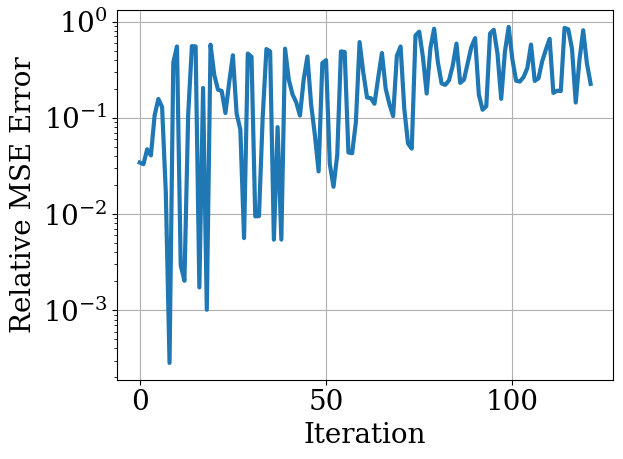

In [16]:
import matplotlib.pyplot as plt

mse1,mse2,mse3,mse4 = mses_const

# Assuming mse2 and mse4 are defined lists of equal length
iterations = list(range(len(mse2)))
relative_error = [(mse4[i] - mse1[i]) / mse1[i] for i in iterations]

plt.figure()
plt.plot(iterations, relative_error)
plt.yscale('log') 
plt.xlabel('Iteration')
plt.ylabel('Relative MSE Error')
# plt.title('Relative Error (mse4 - mse2) / mse2')
# (Actual MSE at the Optimal Equidistant Point – Actual Minimum MSE) / Actual Minimum MSE
plt.grid(True)
plt.show()


In [17]:
from algo.oicd_var import oicd_var

mses_var, _, _,  best_expected_record_value_oicd, func_oicd, _, metric_oicd = oicd_var(
    estimate_loss,
    expectation_loss,
    variance,
    ground_energy,
    n_shot, weights_dict, initial_weights, num_iter,
    cyclic_mode=True, # !!!!!!!!!!!
    use_pratical_interp_flag=False, # !!!!!!!!!!!
    use_local_solvers_flag=False,
    use_global_solvers_flag = False,
    use_eigen_method_flag = True,
    use_exact_update_frequencey_1_flag = False,
    exact_mode=False,  # !!!!!!!!!!!
    plot_flag=False,
    plot_argmin_flag=False,
    tol = tol,
    refresh_print_bar=True,
    mse='nonconstant'
)
all_metrics.append(metric_oicd)

----------------------------------------------------------------------------------------------------


[OICD-var] Iter: 0, 0(20), Metric: 2.4970, Elapsed: 45.06s:   0%|          | 1/250 [00:45<3:06:59, 45.06s/it]

iteration 0
opt_mse_var 18.159417030858584
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 2.082480490408173
mse_var for optimal nodes of mse_const 18.781914612810414



[OICD-var] Iter: 1, 1(20), Metric: 2.4573, Elapsed: 47.33s:   1%|          | 2/250 [01:32<3:11:45, 46.39s/it]

iteration 1
opt_mse_var 10.932894233987051
opt_mse_const 1.9999986666675724
mse_const for optimal nodes of mse_var 2.0966874269241336
mse_var for optimal nodes of mse_const 11.385597814470689



[OICD-var] Iter: 2, 2(20), Metric: 1.7245, Elapsed: 46.42s:   1%|          | 3/250 [02:18<3:11:02, 46.41s/it]

iteration 2
opt_mse_var 11.954925802975264
opt_mse_const 1.9999986666678353
mse_const for optimal nodes of mse_var 2.1125957696558397
mse_var for optimal nodes of mse_const 12.480492445925925



[OICD-var] Iter: 3, 3(20), Metric: 1.5950, Elapsed: 61.23s:   2%|▏         | 4/250 [03:20<3:34:16, 52.26s/it]

iteration 3
opt_mse_var 8.634477946799699
opt_mse_const 1.999998666667922
mse_const for optimal nodes of mse_var 2.07655135448221
mse_var for optimal nodes of mse_const 8.894655995396509



[OICD-var] Iter: 4, 4(20), Metric: 1.5940, Elapsed: 96.63s:   2%|▏         | 5/250 [04:56<4:38:44, 68.26s/it]

iteration 4
opt_mse_var 13.319196480765783
opt_mse_const 1.999998666667619
mse_const for optimal nodes of mse_var 2.2504250515941093
mse_var for optimal nodes of mse_const 14.445368855306707



[OICD-var] Iter: 5, 5(20), Metric: 1.5911, Elapsed: 62.62s:   2%|▏         | 6/250 [05:59<4:29:47, 66.34s/it]

iteration 5
opt_mse_var 9.639815714884662
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 2.306062719861053
mse_var for optimal nodes of mse_const 10.8305088397581



[OICD-var] Iter: 6, 6(20), Metric: 1.2068, Elapsed: 48.36s:   3%|▎         | 7/250 [06:47<4:04:52, 60.46s/it]

iteration 6
opt_mse_var 11.257013515123774
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 2.6191903542378983
mse_var for optimal nodes of mse_const 13.021419522278794



[OICD-var] Iter: 7, 7(20), Metric: 1.1990, Elapsed: 59.90s:   3%|▎         | 8/250 [07:47<4:03:09, 60.29s/it]

iteration 7
opt_mse_var 3.1757949460458335
opt_mse_const 1.9999986666677811
mse_const for optimal nodes of mse_var 2.0253285610205416
mse_var for optimal nodes of mse_const 3.2119226662772444



[OICD-var] Iter: 8, 8(20), Metric: 1.1627, Elapsed: 53.33s:   4%|▎         | 9/250 [08:40<3:53:25, 58.11s/it]

iteration 8
opt_mse_var 2.0271666300424567
opt_mse_const 1.9999986666677345
mse_const for optimal nodes of mse_var 2.0002812949978104
mse_var for optimal nodes of mse_const 2.0274525038062103



[OICD-var] Iter: 9, 9(20), Metric: 1.1592, Elapsed: 57.65s:   4%|▍         | 10/250 [09:38<3:51:52, 57.97s/it]

iteration 9
opt_mse_var 7.096513557436053
opt_mse_const 1.9999986666675558
mse_const for optimal nodes of mse_var 3.291290818909093
mse_var for optimal nodes of mse_const 9.982990493386279



[OICD-var] Iter: 10, 10(20), Metric: 1.0532, Elapsed: 66.79s:   4%|▍         | 11/250 [10:45<4:01:40, 60.67s/it]

iteration 10
opt_mse_var 10.932848317287375
opt_mse_const 1.999998666667557
mse_const for optimal nodes of mse_var 6.484950492183376
mse_var for optimal nodes of mse_const 18.3788643855066



[OICD-var] Iter: 11, 11(20), Metric: 1.0499, Elapsed: 27.60s:   5%|▍         | 12/250 [11:12<3:20:45, 50.61s/it]

iteration 11
opt_mse_var 1.2715769928725107
opt_mse_const 1.9999986666675564
mse_const for optimal nodes of mse_var 2.2350265685124224
mse_var for optimal nodes of mse_const 1.3568100915720267



[OICD-var] Iter: 12, 12(20), Metric: 0.9920, Elapsed: 32.14s:   5%|▌         | 13/250 [11:45<2:57:48, 45.01s/it]

iteration 12
opt_mse_var 0.24951648195416823
opt_mse_const 1.9999986666675598
mse_const for optimal nodes of mse_var 2.0007241992641456
mse_var for optimal nodes of mse_const 0.24960608347072583



[OICD-var] Iter: 13, 13(20), Metric: 0.9923, Elapsed: 58.14s:   6%|▌         | 14/250 [12:43<3:12:39, 48.98s/it]

iteration 13
opt_mse_var 1.1811848684099193
opt_mse_const 1.9999986666675662
mse_const for optimal nodes of mse_var 2.3631099447015895
mse_var for optimal nodes of mse_const 1.3107371720867018



[OICD-var] Iter: 14, 14(20), Metric: 0.9941, Elapsed: 66.72s:   6%|▌         | 15/250 [13:49<3:32:47, 54.33s/it]

iteration 14
opt_mse_var 9.393261640936123
opt_mse_const 1.999998666667562
mse_const for optimal nodes of mse_var 6.056256283241832
mse_var for optimal nodes of mse_const 15.22743486835794



[OICD-var] Iter: 15, 15(20), Metric: 0.9947, Elapsed: 56.60s:   6%|▋         | 16/250 [14:46<3:34:32, 55.01s/it]

iteration 15
opt_mse_var 7.534212568999458
opt_mse_const 1.9999986666675564
mse_const for optimal nodes of mse_var 5.350646343656559
mse_var for optimal nodes of mse_const 12.15182993952194



[OICD-var] Iter: 16, 16(20), Metric: 0.9926, Elapsed: 23.50s:   7%|▋         | 17/250 [15:10<2:56:49, 45.54s/it]

iteration 16
opt_mse_var 0.2915703346384474
opt_mse_const 1.9999986666675944
mse_const for optimal nodes of mse_var 2.000799539050221
mse_var for optimal nodes of mse_const 0.29168724688644154



[OICD-var] Iter: 17, 17(20), Metric: 0.9429, Elapsed: 50.24s:   7%|▋         | 18/250 [16:00<3:01:32, 46.95s/it]

iteration 17
opt_mse_var 2.021192273924911
opt_mse_const 1.9999986666682175
mse_const for optimal nodes of mse_var 2.3482489776042517
mse_var for optimal nodes of mse_const 2.206428153093528



[OICD-var] Iter: 18, 18(20), Metric: 0.9243, Elapsed: 49.63s:   8%|▊         | 19/250 [16:49<3:03:51, 47.76s/it]

iteration 18
opt_mse_var 0.5637936425796429
opt_mse_const 1.9999986666681049
mse_const for optimal nodes of mse_var 2.0090718556301796
mse_var for optimal nodes of mse_const 0.5662701434453636



[OICD-var] Iter: 19, 19(20), Metric: 0.9218, Elapsed: 66.70s:   8%|▊         | 20/250 [17:56<3:24:51, 53.44s/it]

iteration 19
opt_mse_var 9.968973727937927
opt_mse_const 1.999998666667618
mse_const for optimal nodes of mse_var 5.152628585158584
mse_var for optimal nodes of mse_const 15.803490897753695



[OICD-var] Iter: 20, 0(20), Metric: 0.9128, Elapsed: 46.91s:   8%|▊         | 21/250 [18:43<3:16:29, 51.48s/it] 

iteration 20
opt_mse_var 9.978983643384376
opt_mse_const 1.999998666667578
mse_const for optimal nodes of mse_var 3.690357221679296
mse_var for optimal nodes of mse_const 12.609985977161985



[OICD-var] Iter: 21, 1(20), Metric: 0.9073, Elapsed: 38.74s:   9%|▉         | 22/250 [19:22<3:01:06, 47.66s/it]

iteration 21
opt_mse_var 10.868572231972797
opt_mse_const 1.9999986666675647
mse_const for optimal nodes of mse_var 3.968104056222679
mse_var for optimal nodes of mse_const 13.727559931979497



[OICD-var] Iter: 22, 2(20), Metric: 0.8909, Elapsed: 43.02s:   9%|▉         | 23/250 [20:05<2:55:02, 46.27s/it]

iteration 22
opt_mse_var 10.75508122966271
opt_mse_const 1.9999986666675564
mse_const for optimal nodes of mse_var 3.3745042020118268
mse_var for optimal nodes of mse_const 12.607308481644985



[OICD-var] Iter: 23, 3(20), Metric: 0.8260, Elapsed: 51.93s:  10%|▉         | 24/250 [20:57<3:00:40, 47.97s/it]

iteration 23
opt_mse_var 1.8269652735934074
opt_mse_const 1.9999986666675698
mse_const for optimal nodes of mse_var 2.2236141344931815
mse_var for optimal nodes of mse_const 1.9460622953108349



[OICD-var] Iter: 24, 4(20), Metric: 0.8262, Elapsed: 56.73s:  10%|█         | 25/250 [21:53<3:09:44, 50.60s/it]

iteration 24
opt_mse_var 10.636078778410486
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 2.877458133358288
mse_var for optimal nodes of mse_const 12.791398204230804



[OICD-var] Iter: 25, 5(20), Metric: 0.8264, Elapsed: 74.23s:  10%|█         | 26/250 [23:08<3:35:22, 57.69s/it]

iteration 25
opt_mse_var 6.812462930017224
opt_mse_const 1.9999986666675555
mse_const for optimal nodes of mse_var 3.5996578778017065
mse_var for optimal nodes of mse_const 10.061046995628832



[OICD-var] Iter: 26, 6(20), Metric: 0.6912, Elapsed: 89.42s:  11%|█         | 27/250 [24:37<4:09:47, 67.21s/it]

iteration 26
opt_mse_var 10.680709136392633
opt_mse_const 1.9999986666675555
mse_const for optimal nodes of mse_var 2.500793223307347
mse_var for optimal nodes of mse_const 11.86996313325111



[OICD-var] Iter: 27, 7(20), Metric: 0.6899, Elapsed: 47.28s:  11%|█         | 28/250 [25:24<3:46:32, 61.23s/it]

iteration 27
opt_mse_var 2.4879569986094494
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 2.0562295252019136
mse_var for optimal nodes of mse_const 2.5549613053195372



[OICD-var] Iter: 28, 8(20), Metric: 0.6779, Elapsed: 33.93s:  12%|█▏        | 29/250 [25:58<3:15:21, 53.04s/it]

iteration 28
opt_mse_var 1.9332082670908353
opt_mse_const 1.9999986666675635
mse_const for optimal nodes of mse_var 2.016809265162576
mse_var for optimal nodes of mse_const 1.9495920865376628



[OICD-var] Iter: 29, 9(20), Metric: 0.6702, Elapsed: 48.98s:  12%|█▏        | 30/250 [26:47<3:10:01, 51.82s/it]

iteration 29
opt_mse_var 9.157998022178386
opt_mse_const 1.9999986666675966
mse_const for optimal nodes of mse_var 2.750758508555624
mse_var for optimal nodes of mse_const 11.668773327163718



[OICD-var] Iter: 30, 10(20), Metric: 0.6446, Elapsed: 90.41s:  12%|█▏        | 31/250 [28:18<3:51:24, 63.40s/it]

iteration 30
opt_mse_var 12.3026625872483
opt_mse_const 1.9999986666675564
mse_const for optimal nodes of mse_var 3.2268964864919134
mse_var for optimal nodes of mse_const 16.938986932255315



[OICD-var] Iter: 31, 11(20), Metric: 0.6289, Elapsed: 36.15s:  13%|█▎        | 32/250 [28:54<3:20:38, 55.22s/it]

iteration 31
opt_mse_var 3.5740367489482656
opt_mse_const 1.9999986666740117
mse_const for optimal nodes of mse_var 2.086891071842697
mse_var for optimal nodes of mse_const 3.696655285568763



[OICD-var] Iter: 32, 12(20), Metric: 0.6169, Elapsed: 24.39s:  13%|█▎        | 33/250 [29:18<2:46:16, 45.97s/it]

iteration 32
opt_mse_var 1.2748166820076567
opt_mse_const 1.9999986666675613
mse_const for optimal nodes of mse_var 2.0192296936100615
mse_var for optimal nodes of mse_const 1.2863862870046157



[OICD-var] Iter: 33, 13(20), Metric: 0.5041, Elapsed: 61.15s:  14%|█▎        | 34/250 [30:19<3:01:53, 50.53s/it]

iteration 33
opt_mse_var 1.619939959310804
opt_mse_const 1.9999986666677771
mse_const for optimal nodes of mse_var 2.0346960498228204
mse_var for optimal nodes of mse_const 1.6479168095796446



[OICD-var] Iter: 34, 14(20), Metric: 0.4726, Elapsed: 33.47s:  14%|█▍        | 35/250 [30:53<2:42:42, 45.41s/it]

iteration 34
opt_mse_var 9.910130045827538
opt_mse_const 1.9999986666675573
mse_const for optimal nodes of mse_var 3.3702734819903375
mse_var for optimal nodes of mse_const 14.033160192637757



[OICD-var] Iter: 35, 15(20), Metric: 0.4726, Elapsed: 37.83s:  14%|█▍        | 36/250 [31:31<2:33:51, 43.14s/it]

iteration 35
opt_mse_var 8.754225187582964
opt_mse_const 1.9999986666676581
mse_const for optimal nodes of mse_var 3.3053463444753564
mse_var for optimal nodes of mse_const 12.532899662628756



[OICD-var] Iter: 36, 16(20), Metric: 0.4460, Elapsed: 61.57s:  15%|█▍        | 37/250 [32:32<2:52:46, 48.67s/it]

iteration 36
opt_mse_var 1.5232873732101273
opt_mse_const 1.9999986666675555
mse_const for optimal nodes of mse_var 2.0481594500787166
mse_var for optimal nodes of mse_const 1.5582151485442854



[OICD-var] Iter: 37, 17(20), Metric: 0.1544, Elapsed: 36.30s:  15%|█▌        | 38/250 [33:09<2:38:51, 44.96s/it]

iteration 37
opt_mse_var 0.9783372680122583
opt_mse_const 1.9999986666675587
mse_const for optimal nodes of mse_var 2.047320241466455
mse_var for optimal nodes of mse_const 0.9999673886314947



[OICD-var] Iter: 38, 18(20), Metric: 0.1450, Elapsed: 45.95s:  16%|█▌        | 39/250 [33:55<2:39:08, 45.26s/it]

iteration 38
opt_mse_var 1.2140442043968425
opt_mse_const 1.9999986666675555
mse_const for optimal nodes of mse_var 2.307013388677967
mse_var for optimal nodes of mse_const 1.3742239675914738



[OICD-var] Iter: 39, 19(20), Metric: 0.1232, Elapsed: 57.49s:  16%|█▌        | 40/250 [34:52<2:51:14, 48.93s/it]

iteration 39
opt_mse_var 7.232461330723987
opt_mse_const 1.9999986666675773
mse_const for optimal nodes of mse_var 5.959766775084195
mse_var for optimal nodes of mse_const 12.354133982892174



[OICD-var] Iter: 40, 0(20), Metric: 0.1214, Elapsed: 50.73s:  16%|█▋        | 41/250 [35:43<2:52:18, 49.47s/it] 

iteration 40
opt_mse_var 9.818677927123545
opt_mse_const 1.9999986666675555
mse_const for optimal nodes of mse_var 4.142751495840667
mse_var for optimal nodes of mse_const 12.983442668759485



[OICD-var] Iter: 41, 1(20), Metric: 0.1207, Elapsed: 58.70s:  17%|█▋        | 42/250 [36:41<3:01:05, 52.24s/it]

iteration 41
opt_mse_var 11.741864468590677
opt_mse_const 1.9999986666675622
mse_const for optimal nodes of mse_var 4.111050145602812
mse_var for optimal nodes of mse_const 15.133286827003559



[OICD-var] Iter: 42, 2(20), Metric: 0.1168, Elapsed: 39.98s:  17%|█▋        | 43/250 [37:21<2:47:31, 48.56s/it]

iteration 42
opt_mse_var 9.522449490062534
opt_mse_const 1.9999986666675564
mse_const for optimal nodes of mse_var 3.382210619180414
mse_var for optimal nodes of mse_const 11.276720268091852



[OICD-var] Iter: 43, 3(20), Metric: 0.0782, Elapsed: 51.12s:  18%|█▊        | 44/250 [38:13<2:49:21, 49.33s/it]

iteration 43
opt_mse_var 1.1726468076727867
opt_mse_const 1.9999986666688359
mse_const for optimal nodes of mse_var 2.305952265835169
mse_var for optimal nodes of mse_const 1.3075840032753292



[OICD-var] Iter: 44, 4(20), Metric: 0.0759, Elapsed: 39.14s:  18%|█▊        | 45/250 [38:52<2:38:05, 46.27s/it]

iteration 44
opt_mse_var 8.612248245037534
opt_mse_const 1.9999986666675564
mse_const for optimal nodes of mse_var 3.7599797704753044
mse_var for optimal nodes of mse_const 11.20664338484524



[OICD-var] Iter: 45, 5(20), Metric: 0.0747, Elapsed: 41.43s:  18%|█▊        | 46/250 [39:33<2:32:23, 44.82s/it]

iteration 45
opt_mse_var 7.931738619117239
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 3.4938507198514412
mse_var for optimal nodes of mse_const 11.710767104909124



[OICD-var] Iter: 46, 6(20), Metric: 0.0747, Elapsed: 50.12s:  19%|█▉        | 47/250 [40:23<2:37:01, 46.41s/it]

iteration 46
opt_mse_var 8.82962618063377
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 3.16332482258158
mse_var for optimal nodes of mse_const 10.46076859266894



[OICD-var] Iter: 47, 7(20), Metric: 0.0744, Elapsed: 67.58s:  19%|█▉        | 48/250 [41:31<2:57:37, 52.76s/it]

iteration 47
opt_mse_var 0.8287899106341615
opt_mse_const 1.9999986666675582
mse_const for optimal nodes of mse_var 2.2001364782158532
mse_var for optimal nodes of mse_const 0.9066413263118009



[OICD-var] Iter: 48, 8(20), Metric: 0.0697, Elapsed: 69.94s:  20%|█▉        | 49/250 [42:41<3:14:01, 57.92s/it]

iteration 48
opt_mse_var 0.8724618625473787
opt_mse_const 1.9999986666676972
mse_const for optimal nodes of mse_var 2.21075138313752
mse_var for optimal nodes of mse_const 0.9505790867216439



[OICD-var] Iter: 49, 9(20), Metric: 0.0703, Elapsed: 65.70s:  20%|██        | 50/250 [43:46<3:20:50, 60.25s/it]

iteration 49
opt_mse_var 9.211880034035335
opt_mse_const 1.999998666667561
mse_const for optimal nodes of mse_var 4.493129494203284
mse_var for optimal nodes of mse_const 13.26191595696411



[OICD-var] Iter: 50, 10(20), Metric: 0.0624, Elapsed: 53.88s:  20%|██        | 51/250 [44:40<3:13:29, 58.34s/it]

iteration 50
opt_mse_var 8.715898472621731
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 5.826394232266156
mse_var for optimal nodes of mse_const 14.73277741270907



[OICD-var] Iter: 51, 11(20), Metric: 0.0429, Elapsed: 61.90s:  21%|██        | 52/250 [45:42<3:16:03, 59.41s/it]

iteration 51
opt_mse_var 5.135770044652876
opt_mse_const 1.9999986666675744
mse_const for optimal nodes of mse_var 3.01940476683692
mse_var for optimal nodes of mse_const 5.933259979544901



[OICD-var] Iter: 52, 12(20), Metric: 0.0346, Elapsed: 37.60s:  21%|██        | 53/250 [46:20<2:53:34, 52.87s/it]

iteration 52
opt_mse_var 0.4116032778180719
opt_mse_const 1.9999986666678313
mse_const for optimal nodes of mse_var 2.2165578021019914
mse_var for optimal nodes of mse_const 0.4522856292760105



[OICD-var] Iter: 53, 13(20), Metric: 0.0277, Elapsed: 73.25s:  22%|██▏       | 54/250 [47:33<3:12:40, 58.98s/it]

iteration 53
opt_mse_var 0.39789292598392306
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 2.220560100141454
mse_var for optimal nodes of mse_const 0.4401247603569566



[OICD-var] Iter: 54, 14(20), Metric: 0.0257, Elapsed: 84.72s:  22%|██▏       | 55/250 [48:58<3:36:47, 66.71s/it]

iteration 54
opt_mse_var 10.629950974833815
opt_mse_const 1.9999986666688536
mse_const for optimal nodes of mse_var 7.503993810312021
mse_var for optimal nodes of mse_const 17.22443431759007



[OICD-var] Iter: 55, 15(20), Metric: 0.0251, Elapsed: 67.56s:  22%|██▏       | 56/250 [50:05<3:36:30, 66.96s/it]

iteration 55
opt_mse_var 6.906144802761941
opt_mse_const 1.9999986666930472
mse_const for optimal nodes of mse_var 7.54504252559583
mse_var for optimal nodes of mse_const 12.292250698622032



[OICD-var] Iter: 56, 16(20), Metric: 0.0253, Elapsed: 82.27s:  23%|██▎       | 57/250 [51:28<3:50:10, 71.55s/it]

iteration 56
opt_mse_var 0.7725487321633229
opt_mse_const 1.9999986666685796
mse_const for optimal nodes of mse_var 3.305863164986909
mse_var for optimal nodes of mse_const 1.0989242431621888



[OICD-var] Iter: 57, 17(20), Metric: 0.0227, Elapsed: 59.31s:  23%|██▎       | 58/250 [52:27<3:37:13, 67.88s/it]

iteration 57
opt_mse_var 0.39659949312372217
opt_mse_const 1.9999986666675562
mse_const for optimal nodes of mse_var 2.340845545386485
mse_var for optimal nodes of mse_const 0.452188603405485



[OICD-var] Iter: 58, 18(20), Metric: 0.0170, Elapsed: 104.63s:  24%|██▎       | 59/250 [54:12<4:11:10, 78.91s/it]

iteration 58
opt_mse_var 0.7419338143990775
opt_mse_const 1.9999986666678717
mse_const for optimal nodes of mse_var 3.486659901210846
mse_var for optimal nodes of mse_const 1.081937062042489



[OICD-var] Iter: 59, 19(20), Metric: 0.0170, Elapsed: 95.27s:  24%|██▍       | 60/250 [55:47<4:25:25, 83.82s/it] 

iteration 59
opt_mse_var 6.738646468749229
opt_mse_const 1.9999986666690517
mse_const for optimal nodes of mse_var 9.031616540153056
mse_var for optimal nodes of mse_const 12.241356028521585



[OICD-var] Iter: 60, 0(20), Metric: 0.0148, Elapsed: 80.56s:  24%|██▍       | 61/250 [57:07<4:20:56, 82.84s/it] 

iteration 60
opt_mse_var 9.246060654552299
opt_mse_const 1.9999986666675613
mse_const for optimal nodes of mse_var 7.672961395352079
mse_var for optimal nodes of mse_const 13.022653026691497



[OICD-var] Iter: 61, 1(20), Metric: 0.0124, Elapsed: 37.34s:  25%|██▍       | 62/250 [57:45<3:36:47, 69.19s/it]

iteration 61
opt_mse_var 10.928113617271801
opt_mse_const 1.9999986666675778
mse_const for optimal nodes of mse_var 7.9608075917113625
mse_var for optimal nodes of mse_const 14.610479268239775



[OICD-var] Iter: 62, 2(20), Metric: 0.0126, Elapsed: 70.11s:  25%|██▌       | 63/250 [58:55<3:36:30, 69.47s/it]

iteration 62
opt_mse_var 7.736413598371174
opt_mse_const 1.9999986666676914
mse_const for optimal nodes of mse_var 6.605275512570292
mse_var for optimal nodes of mse_const 9.568306166448336



[OICD-var] Iter: 63, 3(20), Metric: 0.0127, Elapsed: 54.33s:  26%|██▌       | 64/250 [59:49<3:21:16, 64.93s/it]

iteration 63
opt_mse_var 1.070097916197251
opt_mse_const 1.9999986666675706
mse_const for optimal nodes of mse_var 3.4350744079095623
mse_var for optimal nodes of mse_const 1.3371126298717162



[OICD-var] Iter: 64, 4(20), Metric: 0.0132, Elapsed: 45.94s:  26%|██▌       | 65/250 [1:00:35<3:02:37, 59.23s/it]

iteration 64
opt_mse_var 7.490409217619499
opt_mse_const 1.9999986666676026
mse_const for optimal nodes of mse_var 7.276993702456744
mse_var for optimal nodes of mse_const 10.66200736545418



[OICD-var] Iter: 65, 5(20), Metric: 0.0142, Elapsed: 50.31s:  26%|██▋       | 66/250 [1:01:25<2:53:26, 56.56s/it]

iteration 65
opt_mse_var 6.766014783305036
opt_mse_const 1.9999986666675569
mse_const for optimal nodes of mse_var 9.447804644907038
mse_var for optimal nodes of mse_const 11.992021950113203



[OICD-var] Iter: 66, 6(20), Metric: 0.0159, Elapsed: 42.44s:  27%|██▋       | 67/250 [1:02:08<2:39:35, 52.32s/it]

iteration 66
opt_mse_var 7.347704693988025
opt_mse_const 1.999998666667556
mse_const for optimal nodes of mse_var 5.567965289745464
mse_var for optimal nodes of mse_const 9.049744900449262



[OICD-var] Iter: 67, 7(20), Metric: 0.0159, Elapsed: 64.41s:  27%|██▋       | 68/250 [1:03:12<2:49:42, 55.95s/it]

iteration 67
opt_mse_var 0.7507830461526595
opt_mse_const 1.9999986666675555
mse_const for optimal nodes of mse_var 3.397669194813976
mse_var for optimal nodes of mse_const 0.9805048255330304



[OICD-var] Iter: 68, 8(20), Metric: 0.0107, Elapsed: 44.42s:  28%|██▊       | 69/250 [1:03:57<2:38:20, 52.49s/it]

iteration 68
opt_mse_var 0.5970667465851451
opt_mse_const 1.9999986666713243
mse_const for optimal nodes of mse_var 3.599873167883758
mse_var for optimal nodes of mse_const 0.8116064093256112



[OICD-var] Iter: 69, 9(20), Metric: 0.0106, Elapsed: 40.52s:  28%|██▊       | 70/250 [1:04:37<2:26:42, 48.90s/it]

iteration 69
opt_mse_var 8.100443214032612
opt_mse_const 1.9999986666675862
mse_const for optimal nodes of mse_var 10.310059340279546
mse_var for optimal nodes of mse_const 13.002217770926464



[OICD-var] Iter: 70, 10(20), Metric: 0.0096, Elapsed: 103.78s:  28%|██▊       | 70/250 [1:06:21<2:50:38, 56.88s/it]

iteration 70
opt_mse_var 7.713481063655107
opt_mse_const 1.9999986666678948
mse_const for optimal nodes of mse_var 14.42493306386722
mse_var for optimal nodes of mse_const 14.395639042231817



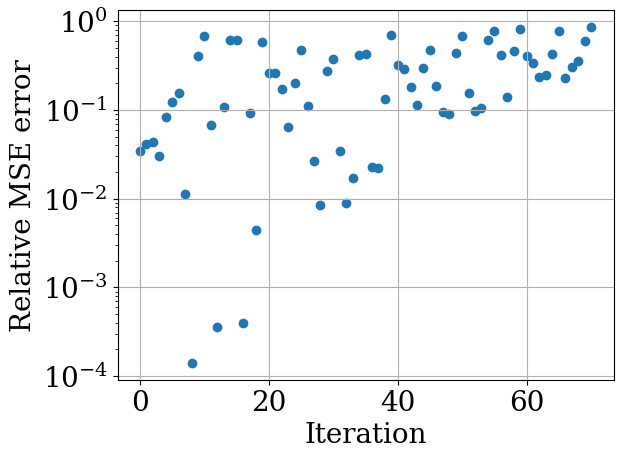

In [29]:
import matplotlib.pyplot as plt

mse1,mse2,mse3,mse4 = mses_var

# Assuming mse2 and mse4 are defined lists of equal length
iterations = list(range(len(mse2)))
relative_error = [(mse4[i] - mse1[i]) / mse1[i] for i in iterations]

plt.figure()
plt.scatter(iterations, relative_error)
plt.yscale('log') 
plt.xlabel('Iteration')
plt.ylabel('Relative MSE error')
# plt.title('Relative Error (mse4 - mse2) / mse2')
# (Actual MSE at the Optimal Equidistant Point – Actual Minimum MSE) / Actual Minimum MSE
plt.savefig('mse_no_const_var_2.png')
plt.grid(True)
plt.show()



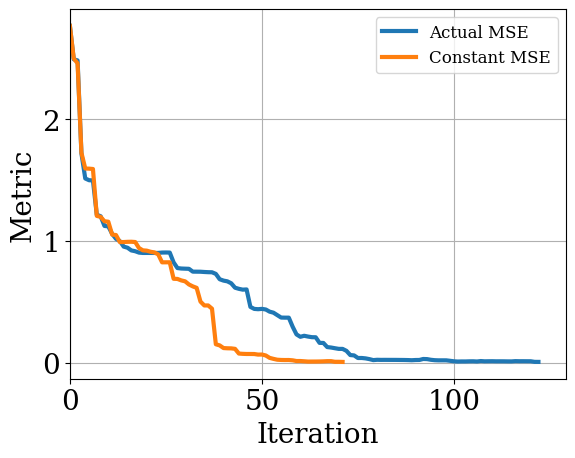

In [19]:
# Plot the results
plt.figure()

# Loop through and plot the best_expected_record_value_oicd for each configuration
for idx, values in enumerate(all_metrics):
    # label=f'k = {k_set[idx]}, MSE = {MSE_values[idx]:.0f}'
    if idx == 1:
        plt.plot(values, label="Constant MSE")
    if idx == 0:
        plt.plot(values, label="Actual MSE")

# Customize the plot
plt.xlabel("Iteration")
plt.ylabel("Metric")
plt.xlim(0, max(len(values) for values in all_metrics)*1.05)
# plt.title("Noisy data with vanilla ICD")
plt.legend()
plt.grid(True)
plt.savefig('mse_no_const_var_1.png')
plt.show()